## MVA: Reinforcement Learning TP2
# The Exploration-Exploitation Dilemna

Author: Ramy Ghorayeb

Date: November 2018

### **1.1 Bernoulli bandit models**

In [237]:
import numpy as np
import math
import matplotlib.pyplot as plt
import arms

arm1 = arms.ArmBernoulli(0.30, random_state=np.random.randint(1, 100000))
arm2 = arms.ArmBernoulli(0.20, random_state=np.random.randint(1, 100000))
arm3 = arms.ArmBernoulli(0.15, random_state=np.random.randint(1, 100000))
arm4 = arms.ArmBernoulli(0.10, random_state=np.random.randint(1, 100000))

MAB = [arm1, arm2, arm3, arm4]

1.

In [274]:
def UCB1(T,MAB,rho=0.2):
    nb_arms = len(MAB)
    T = T + nb_arms
    A = np.zeros(T)
    B = np.zeros(nb_arms)    
    N, S = np.zeros((len(MAB),T)), np.zeros((len(MAB),T))
    
    # initialization
    for i in range(nb_arms):
        N[i][i] = 1
        S[i][i] = MAB[i].sample()

    # for t>K    
    for t in range(nb_arms-1,T-1):
        for arm in range(nb_arms):
            Na = N[arm][:t+1].sum()
            Sa = S[arm][:t+1].sum()
            mu = Sa/Na
            B[arm] = mu + rho*math.sqrt(math.log(t)/(2*Na))
        A[t+1] = np.argmax(B)
        arm_chosen = int(A[t+1])
        N[arm_chosen][t+1] = 1
        S[arm_chosen][t+1] = MAB[arm_chosen].sample()     
        
    return S.T[nb_arms:].T, N.T[nb_arms:].T

def TS(T,MAB):
    nb_arms = len(MAB)
    T = T + 1
    A = np.zeros(T)
    Pi = np.zeros(nb_arms)  
    N, S = np.zeros((len(MAB),T)),np.zeros((len(MAB),T))
    
    # prior distribution
    A[0] = np.argmax(np.random.rand(4))
    arm_chosen = int(A[0])
    N[arm_chosen][0] = 1
    S[arm_chosen][0] = MAB[arm_chosen].sample()  
    
    # posterior distribution    
    for t in range(T-1):
        for arm in range(nb_arms):
            Na = N[arm][:t+1].sum()
            Sa = S[arm][:t+1].sum()
            Pi[arm] = np.random.beta(Sa+1,Na-Sa+1)
        A[t+1] = np.argmax(Pi)
        arm_chosen = int(A[t+1])
        
        N[arm_chosen][t+1] = 1
        S[arm_chosen][t+1] = MAB[arm_chosen].sample()   
            
    return S, N

def Greedy(T,MAB):
    N, S = np.zeros((len(MAB),T)),np.zeros((len(MAB),T))    
    arm_chosen = np.argmax(np.array([MAB[i].p for i in range(len(MAB))]))
    reward = max(np.array([MAB[i].p for i in range(len(MAB))]))
    for t in range(T):
        N[arm_chosen][t] = 1
        S[arm_chosen][t] = MAB[arm_chosen].sample()
    
    return S, N

2.

Expected regret of UCB1, Thompson Sampling and Greedy policy

In [334]:
def exp_Regret(T, MAB, Algo, n_simulations=500):
    
    sum_rew = np.zeros((n_simulations,T))
    reg = np.zeros(T)
    
    for s in range(n_simulations):
        rew, draws = Algo(T, MAB)
        for t in range(T):
            sum_rew[s][t] =  rew.T[:t].sum()

    rho_s = max([MAB[i].p for i in range(len(MAB))])

    for t in range(T):
        esp_rew = sum_rew.T[t].mean()
        reg[t] = (t+1)*rho_s - esp_rew
            
    return reg

In [339]:
exp_reg_UCB1 = exp_Regret(1000, MAB, UCB1, n_simulations=250)
print('Estimated expected regret of UCB1 algorithm: ',exp_reg_UCB1[-1])

exp_reg_TS = exp_Regret(1000, MAB, TS, n_simulations=250)
print('Estimated expected regret of TS algorithm: ',exp_reg_TS[-1])

exp_reg_Greedy = exp_Regret(1000, MAB, Greedy, n_simulations=250)
print('Estimated expected regret of Greedy algorithm: ',exp_reg_Greedy[-1])

Estimated expected regret of UCB1 algorithm:  34.148000000000025
Estimated expected regret of TS algorithm:  23.091999999999985
Estimated expected regret of Greedy algorithm:  -1.363999999999976


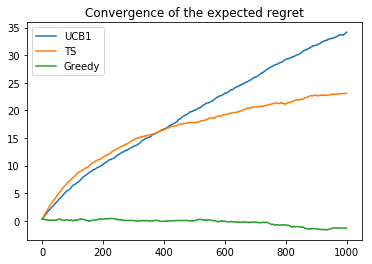

In [340]:
plt.plot(exp_reg_UCB1,label='UCB1')
plt.plot(exp_reg_TS,label='TS')
plt.plot(exp_reg_Greedy,label='Greedy')
plt.title('Convergence of the expected regret')
plt.legend()

3.

In [402]:
def Complexity(MAB):
    nb_arms = len(MAB)
    ps = max([MAB[i].p for i in range(nb_arms)])
    C = np.zeros(nb_arms)
    
    def kl(x,y):
        return x*math.log(x/y)+(1-x)*math.log((1-x)/(1-y))
    
    for arm in range(nb_arms):
        pa = MAB[arm].p
        if pa != ps:
            C[arm] = (ps - pa)/kl(pa,ps)
    return C.sum()

In [403]:
def Oracle(T, MAB):
    C = np.zeros(1000)
    for t in range(T):
        C[t] = Complexity(MAB)*math.log(t+1)
    return C

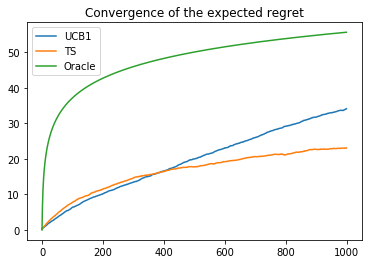

In [404]:
exp_reg_Oracle = Oracle(1000,MAB)

plt.plot(exp_reg_UCB1,label='UCB1')
plt.plot(exp_reg_TS,label='TS')
plt.plot(exp_reg_Oracle,label='Oracle')
plt.title('Convergence of the expected regret')
plt.legend()

The graph is strange and could seem in contradiction with Lai and Robbins lower bound but the oracle regret curbe is not under UCB1's and TS' because T is not converging to infinity

**Q1**

In [405]:
arm1 = arms.ArmBernoulli(0.25, random_state=np.random.randint(1, 100000))
arm2 = arms.ArmBernoulli(0.20, random_state=np.random.randint(1, 100000))
arm3 = arms.ArmBernoulli(0.15, random_state=np.random.randint(1, 100000))
arm4 = arms.ArmBernoulli(0.10, random_state=np.random.randint(1, 100000))

MAB1 = [arm1, arm2, arm3, arm4]

arm5 = arms.ArmBernoulli(0.45, random_state=np.random.randint(1, 100000))
arm6 = arms.ArmBernoulli(0.30, random_state=np.random.randint(1, 100000))
arm7 = arms.ArmBernoulli(0.25, random_state=np.random.randint(1, 100000))
arm8 = arms.ArmBernoulli(0.20, random_state=np.random.randint(1, 100000))

MAB2 = [arm5, arm6, arm7, arm8]

In [409]:
print('MAB1: ---')
exp_reg_UCB11 = exp_Regret(1000, MAB1, UCB1, n_simulations=250)
print('Estimated expected regret of UCB1 algorithm: ',exp_reg_UCB1[-1])
exp_reg_TS1 = exp_Regret(1000, MAB1, TS, n_simulations=250)
print('Estimated expected regret of TS algorithm: ',exp_reg_TS[-1])
exp_reg_Oracle1 = Oracle(1000,MAB1)
print('Estimated expected regret of Oracle: ',exp_reg_Oracle[-1])

print('MAB2: ---')
exp_reg_UCB12 = exp_Regret(1000, MAB2, UCB1, n_simulations=250)
print('Estimated expected regret of UCB1 algorithm: ',exp_reg_UCB1[-1])
exp_reg_TS2 = exp_Regret(1000, MAB2, TS, n_simulations=250)
print('Estimated expected regret of TS algorithm: ',exp_reg_TS[-1])
exp_reg_Oracle2 = Oracle(1000,MAB2)
print('Estimated expected regret of Oracle: ',exp_reg_Oracle[-1])

MAB1: ---
Estimated expected regret of UCB1 algorithm:  34.148000000000025
Estimated expected regret of TS algorithm:  23.091999999999985
Estimated expected regret of Oracle:  55.69132534779637
MAB2: ---
Estimated expected regret of UCB1 algorithm:  34.148000000000025
Estimated expected regret of TS algorithm:  23.091999999999985
Estimated expected regret of Oracle:  55.69132534779637


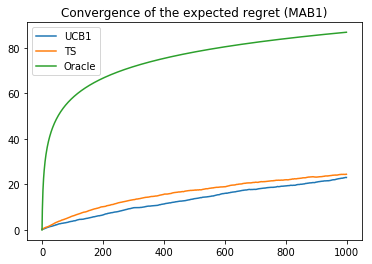

In [411]:
plt.plot(exp_reg_UCB11,label='UCB1')
plt.plot(exp_reg_TS1,label='TS')
plt.plot(exp_reg_Oracle1,label='Oracle')
plt.title('Convergence of the expected regret (MAB1)')
plt.legend()

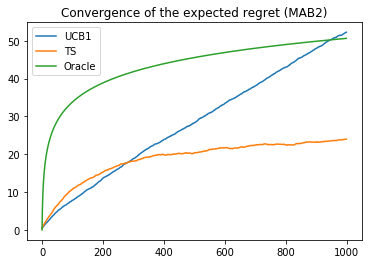

In [412]:
plt.plot(exp_reg_UCB12,label='UCB1')
plt.plot(exp_reg_TS2,label='TS')
plt.plot(exp_reg_Oracle2,label='Oracle')
plt.title('Convergence of the expected regret (MAB2)')
plt.legend()

We can see that UCB1's expected regret in MAB2 case has crossed the curve of Oracle, helping us viewing the  Lai and Robbins lower bound when T converging to infinity 

### **1.2 Non-parametric bandits (bounded rewards)**

1.

In [413]:
arm1 = arms.ArmBernoulli(0.45, random_state=np.random.randint(1, 100000))
arm2 = arms.ArmBeta(2,3, random_state=np.random.randint(1, 100000))
arm3 = arms.ArmExp(2, random_state=np.random.randint(1, 100000))
arm4 = arms.ArmBernoulli(0.10, random_state=np.random.randint(1, 100000))

MAB = [arm1, arm2, arm3, arm4]

2. **NOT COMPLETED**

In [ ]:
def TS_adapted(T,MAB):
    nb_arms = len(MAB)
    T = T + 1
    A = np.zeros(T)
    Pi = np.zeros(nb_arms)  
    N, S = np.zeros((len(MAB),T)),np.zeros((len(MAB),T))
    
    # prior distribution
    A[0] = np.argmax(np.random.rand(4))
    arm_chosen = int(A[0])
    N[arm_chosen][0] = 1
    S[arm_chosen][0] = MAB[arm_chosen].sample()  
    
    # posterior distribution    
    for t in range(T-1):
        for arm in range(nb_arms):
            Na = N[arm][:t+1].sum()
            Sa = S[arm][:t+1].sum()
            # modify with a new distribution
            Pi[arm] = np.random.beta(Sa+1,Na-Sa+1)
        A[t+1] = np.argmax(Pi)
        arm_chosen = int(A[t+1])
        
        N[arm_chosen][t+1] = 1
        S[arm_chosen][t+1] = MAB[arm_chosen].sample()   
            
    return S, N

**Q2**

## 2. Linear Bandit on Real Data